In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('mnist_train.csv')
test = pd.read_csv('mnist_test.csv')

In [3]:
train.head()

,5,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.608,0.609,0.610,0.611,0.612,0.613,0.614,0.615,0.616,0.617
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
dict_x_train = train.ix[:,'0':]
pixel_train = dict_x_train.as_matrix()
dict_y_train = train.ix[:,'5']
label = dict_y_train.as_matrix()

dict_x_test = test.ix[:,'0':]
pixel_test = dict_x_test.as_matrix()
dict_y_test = test.ix[:,'7']
label_test = dict_y_test.as_matrix()

In [5]:
np.shape(pixel_test)

(9999, 784)

In [6]:
mean_train = np.mean(pixel_train,axis = 1)
std_train = np.std(pixel_train,axis = 1)

mean_test = np.mean(pixel_test,axis = 1)
std_test = np.std(pixel_test,axis = 1)

Pre-processing the data. np.tile create matrix with duplicated rows or columns

In [7]:
mean_temp_train = np.tile(mean_train,[784,1])
mean_temp_train = mean_temp_train.transpose()

std_temp_train = np.tile(std_train,[784,1])
std_temp_train = std_temp_train.transpose()


mean_temp_test = np.tile(mean_test,[784,1])
mean_temp_test = mean_temp_test.transpose()

std_temp_test = np.tile(std_test,[784,1])
std_temp_test = std_temp_test.transpose()

In [8]:
zero_mean_train = pixel_train - mean_temp_train
data = zero_mean_train/std_temp_train


zero_mean_test = pixel_test - mean_temp_test
test_data = zero_mean_test/std_temp_test

In [9]:
train_data = data

In [10]:
data = train_data[0:42000,:]
validate = train_data[42001:54000,:]
testdata = train_data[54001:59998,:]

label_data = label[0:42000]
label_validate = label[42001:54000]
label_test = label[54001:59998]

In [11]:
def one_hot_encoding(x):
    temp = np.zeros((len(x), 10))             #10 classes
    temp[np.arange(len(x)), x] = 1
    return temp

In [12]:
img_size = 28

img_size_flat = img_size * img_size

img_shape = (img_size, img_size)

first_layer = 1000

second_layer = 1300

third_layer = 1500

num_classes = 10

In [13]:
x = tf.placeholder(tf.float32, [None, img_size_flat])
y_true = tf.placeholder(tf.float32, [None, num_classes])
y_true_cls = tf.placeholder(tf.int64, [None])

In [14]:
first_weights = tf.Variable(tf.random_normal([img_size_flat, first_layer]))
first_biases = tf.Variable(tf.zeros([first_layer]))

second_weights = tf.Variable(tf.random_normal([first_layer, second_layer]))
second_biases = tf.Variable(tf.zeros([second_layer]))

third_weights = tf.Variable(tf.random_normal([second_layer, third_layer]))
third_biases = tf.Variable(tf.zeros([third_layer]))

last_weights = tf.Variable(tf.random_normal([third_layer,num_classes]))
last_biases = tf.Variable(tf.zeros([num_classes]))

In [15]:
z1 = tf.matmul(x,first_weights) + first_biases
a1 = tf.nn.relu(z1)

z2 = tf.matmul(a1, second_weights) + second_biases
a2 = tf.nn.relu(z2)

z3 = tf.matmul(a2, third_weights) + third_biases
a3 = tf.nn.relu(z3)

logits = tf.matmul(a3, last_weights) + last_biases

In [16]:
y_pred = tf.nn.softmax(logits)
y_pred_cls = tf.argmax(y_pred, dimension=1)
y_pred

<tf.Tensor 'Softmax:0' shape=(?, 10) dtype=float32>

# L2 regularizations

In [17]:
lamda = 0
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits,
                                                        labels=y_true)
cost = tf.reduce_mean(cross_entropy
                      +lamda*tf.nn.l2_loss(first_weights)
                      +lamda*tf.nn.l2_loss(second_weights)
                      +lamda*tf.nn.l2_loss(third_weights)
                      +lamda*tf.nn.l2_loss(last_weights))

In [18]:
optimizer = tf.train.AdamOptimizer().minimize(cost)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [19]:
def one_hot_encoding(x):
    temp = np.zeros((len(x), 10))             #10 classes
    temp[np.arange(len(x)), x] = 1
    return temp

In [20]:
session = tf.Session()
session.run(tf.global_variables_initializer())

In [21]:
batch_size = 100
steps = len(data)/batch_size
#steps = 800/batch_size
steps = int(steps)
err_test = list()
err_validate = list()
acc_test = list()
acc_validate = list()
def optimize(num_iterations):
    for i in range(num_iterations):
        k = 0
        for j in range(steps):
            x_batch = data[k:k+ batch_size,:] 
            y_true_batch = label_data[k:k+ batch_size]

            y_true_batch = one_hot_encoding(y_true_batch)
           
            k = k + batch_size
            feed_dict_train = {x: x_batch,
                               y_true: y_true_batch}
            session.run(optimizer, feed_dict=feed_dict_train)
            
        err_test.append(print_loss(feed_dict_test))
        err_validate.append(print_loss(feed_dict_validate))
        print("time: {0}, acc on data: {1}, acc on validate: {2}".format(i, print_accuracy(feed_dict_test), print_accuracy(feed_dict_validate)))
        acc_validate.append(print_accuracy(feed_dict_validate))
        acc_test.append(print_accuracy(feed_dict_test))

In [22]:
feed_label_validate = one_hot_encoding(label_validate)
validate_class = np.array([label.argmax() for label in feed_label_validate])
feed_dict_validate = {x: validate,
                  y_true: feed_label_validate,
                  y_true_cls: validate_class}

In [23]:
feed_label_test = one_hot_encoding(label_data)
test_class = np.array([label.argmax() for label in feed_label_test])
feed_dict_test = {x: data,
                  y_true: feed_label_test,
                  y_true_cls: test_class}

In [24]:
def print_accuracy(feed_dict_):
    # Use TensorFlow to compute the accuracy.
    acc = session.run(accuracy, feed_dict_)
    
    # Print the accuracy.
    #print("Accuracy on test-set: {0:.1%}".format(acc))
    return acc

In [25]:
def print_loss(feed_dict_):
    # Use TensorFlow to compute the accuracy.
    acc = session.run(cost, feed_dict_)
    
    # Print the accuracy.
    #print("Accuracy on test-set: {0:.1%}".format(acc))
    return acc

In [26]:
err_validate.append(print_loss(feed_dict_validate))
err_test.append(print_loss(feed_dict_test))


acc_validate.append(print_accuracy(feed_dict_validate))
acc_test.append(print_accuracy(feed_dict_test))

In [27]:
optimize(num_iterations=100)

time: 0, acc on data: 0.9230238199234009, acc on validate: 0.8933244347572327
time: 1, acc on data: 0.9640476107597351, acc on validate: 0.9246603846549988
time: 2, acc on data: 0.9797142744064331, acc on validate: 0.933994472026825
time: 3, acc on data: 0.9764761924743652, acc on validate: 0.9304941892623901
time: 4, acc on data: 0.9871190190315247, acc on validate: 0.9421618580818176
time: 5, acc on data: 0.9883333444595337, acc on validate: 0.9437453150749207
time: 6, acc on data: 0.9914523959159851, acc on validate: 0.9460788369178772
time: 7, acc on data: 0.9924761652946472, acc on validate: 0.948078989982605
time: 8, acc on data: 0.9932857155799866, acc on validate: 0.9528294205665588
time: 9, acc on data: 0.9880475997924805, acc on validate: 0.9461621642112732
time: 10, acc on data: 0.9866666793823242, acc on validate: 0.9427452087402344


KeyboardInterrupt: 

In [33]:
np_first_weights = session.run(first_weights)
np_first_biases = session.run(first_biases)

df_1weights = pd.DataFrame(np_first_weights)
df_1biases = pd.DataFrame(np_first_biases)

df_1weights.to_csv('1st_weights')
df_1biases.to_csv('1st_biases')

In [34]:
np_second_weights = session.run(second_weights)
np_second_biases = session.run(second_biases)

df_2weights = pd.DataFrame(np_second_weights)
df_2biases = pd.DataFrame(np_second_biases)

df_2weights.to_csv('2nd_weights')
df_2biases.to_csv('2nd_biases')

In [35]:
np_third_weights = session.run(third_weights)
np_third_biases = session.run(third_biases)

df_3weights = pd.DataFrame(np_third_weights)
df_3biases = pd.DataFrame(np_third_biases)

df_3weights.to_csv('3rd_weights')
df_3biases.to_csv('3rd_biases')

In [36]:
np_last_weights = session.run(last_weights)
np_last_biases = session.run(last_biases)

df_lstweights = pd.DataFrame(np_last_weights)
df_lstbiases = pd.DataFrame(np_last_biases)

df_lstweights.to_csv('lst_weights')
df_lstbiases.to_csv('lst_biases')

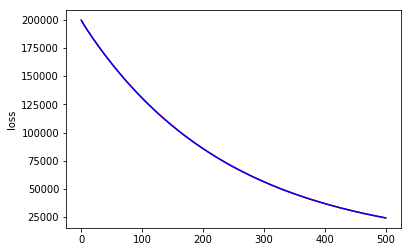

In [28]:
fig = plt.figure()
plt.plot(range(len(err_test)),err_test,'r')
plt.plot(range(len(err_validate)),err_validate,'b')
plt.ylabel('loss')
#plt.title('accuracy on validate data')
plt.show()
fig.savefig('Adam_loss_3layers_1000_1300_1500_alpha000001reg05.png')

In [ ]:
fig = plt.figure()
plt.plot(range(len(acc_test)),acc_test,'r')
plt.plot(range(len(acc_validate)),acc_validate,'b')
plt.ylabel('acc')
#plt.title('accuracy on validate data')
plt.show()
fig.savefig('Adam_acc_3layers_1000_1300_1500_alpha000001reg05.png')